# 1.8 – Sorting Arrays

Up to this point we have been concerned mainly with tools to access and operate on array data with NumPy.
This section covers algorithms related to sorting values in NumPy arrays.
These algorithms are a favorite topic in introductory computer science courses: if you've ever taken one, you probably have had dreams (or, depending on your temperament, nightmares) about *insertion sorts*, *selection sorts*, *merge sorts*, *quick sorts*, *bubble sorts*, and many, many more.
All are means of accomplishing a similar task: sorting the values in a list or array.

For example, a simple *selection sort* repeatedly finds the minimum value from a list, and makes swaps until the list is sorted. We can code this in just a few lines of Python:

In [2]:
import numpy as np

def selection_sort(x):
    for i in range(len(x)):
        swap = i + np.argmin(x[i:])
        (x[i], x[swap]) = (x[swap], x[i])
    return x

In [3]:
x = np.array([2, 1, 4, 3, 5])
selection_sort(x)

array([1, 2, 3, 4, 5])

As any first-year computer science major will tell you, the selection sort is useful for its simplicity, but is much too slow to be useful for larger arrays.
For a list of $N$ values, it requires $N$ loops, each of which does on order $\sim N$ comparisons to find the swap value.
In terms of the "big-O" notation often used to characterize these algorithms (see [Big-O Notation](#Aside:-Big-O-Notation)), selection sort averages $\mathcal{O}[N^2]$: if you double the number of items in the list, the execution time will go up by about a factor of four.

Even selection sort, though, is much better than my all-time favorite sorting algorithms, the *bogosort*:

In [5]:
def bogosort(x):
    while np.any(x[:-1] > x[1:]):
        np.random.shuffle(x)
    return x

In [6]:
x = np.array([2, 1, 4, 3, 5])
bogosort(x)

array([1, 2, 3, 4, 5])

This silly sorting method relies on pure chance: it repeatedly applies a random shuffling of the array until the result happens to be sorted.
With an average scaling of $\mathcal{O}[N \times N!]$, (that's *N* times *N* factorial) this should–quite obviously–never be used for any real computation.

Fortunately, Python contains built-in sorting algorithms that are *much* more efficient than either of the simplistic algorithms just shown. We'll start by looking at the Python built-ins, and then take a look at the routines included in NumPy and optimized for NumPy arrays.

## Fast Sorting in NumPy: ``np.sort`` and ``np.argsort``

Although Python has built-in ``sort`` and ``sorted`` functions to work with lists, we won't discuss them here because NumPy's ``np.sort`` function turns out to be much more efficient and useful for our purposes.
By default ``np.sort`` uses an $\mathcal{O}[N\log N]$, *[quicksort](https://en.wikipedia.org/wiki/Quicksort)* algorithm, though *mergesort* and *heapsort* are also available. For most applications, the default quicksort is more than sufficient.

To return a sorted version of the array *without modifying the input*, you can use ``np.sort``:

In [5]:
x = np.array([2, 1, 4, 3, 5])
np.sort(x)

array([1, 2, 3, 4, 5])

If you prefer to sort the array in-place, you can instead use the ``sort`` method of arrays:

In [6]:
x.sort()
print(x)

[1 2 3 4 5]


A related function is ``argsort``, which instead returns the *indices* of the sorted elements:

In [7]:
x = np.array([2, 1, 4, 3, 5])
i = np.argsort(x)
print(i)

[1 0 3 2 4]


The first element of this result gives the index of the smallest element, the second value gives the index of the second smallest, and so on.
These indices can then be used (via fancy indexing) to construct the sorted array if desired:

In [8]:
x[i]

array([1, 2, 3, 4, 5])

There are two more related functions that you might find useful, one has been already mentioned above:

In [11]:
print(np.argmax(x))
print(np.argmin(x))

4
1


### Sorting along rows or columns

A useful feature of NumPy's sorting algorithms is the ability to sort along specific rows or columns of a multidimensional array using the ``axis`` argument. For example:

In [15]:
rand = np.random.RandomState(42)
X = rand.randint(0, 10, (4, 6))
print(X)

[[6 3 7 4 6 9]
 [2 6 7 4 3 7]
 [7 2 5 4 1 7]
 [5 1 4 0 9 5]]


In [16]:
# sort each column of X
np.sort(X, axis=0)

array([[2, 1, 4, 0, 1, 5],
       [5, 2, 5, 4, 3, 7],
       [6, 3, 7, 4, 6, 7],
       [7, 6, 7, 4, 9, 9]])

In [17]:
# sort each row of X
np.sort(X, axis=1)

array([[3, 4, 6, 6, 7, 9],
       [2, 3, 4, 6, 7, 7],
       [1, 2, 4, 5, 7, 7],
       [0, 1, 4, 5, 5, 9]])

Keep in mind that this treats each row or column as an independent array, and any relationships between the row or column values will be lost!

## Partial Sorts: Partitioning

Sometimes we're not interested in sorting the entire array, but simply want to find the *k* smallest values in the array. NumPy provides this in the ``np.partition`` function. ``np.partition`` takes an array and a number *K*; the result is a new array with the smallest *K* values to the left of the partition, and the remaining values to the right, in arbitrary order:

In [18]:
x = np.array([7, 2, 3, 1, 6, 5, 4])
np.partition(x, 3)

array([2, 1, 3, 4, 6, 5, 7])

Note that the first three values in the resulting array are the three smallest in the array, and the remaining array positions contain the remaining values.
Within the two partitions, the elements have arbitrary order.

Similarly to sorting, we can partition along an arbitrary axis of a multidimensional array:

In [19]:
np.partition(X, 2, axis=1)

array([[3, 4, 6, 7, 6, 9],
       [2, 3, 4, 7, 6, 7],
       [1, 2, 4, 5, 7, 7],
       [0, 1, 4, 5, 9, 5]])

The result is an array where the first two slots in each row contain the smallest values from that row, with the remaining values filling the remaining slots.

Finally, just as there is a ``np.argsort`` that computes indices of the sort, there is a ``np.argpartition`` that computes indices of the partition.
We'll see this in action in the following section.

## Example: k-Nearest Neighbors

Let's quickly see how we might use this ``argsort`` function along multiple axes to find the nearest neighbors of each point in a set.
We'll start by creating a random set of 10 points on a two-dimensional plane.
Using the standard convention, we'll arrange these in a $10\times 2$ array:

In [97]:
X = rand.rand(10, 2)

To get an idea of how these points look, let's quickly scatter plot them:

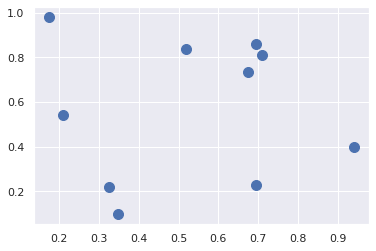

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # Plot styling
plt.scatter(X[:, 0], X[:, 1], s=100);

Now we'll compute the distance between each pair of points.
Recall that the squared-distance between two points is the sum of the squared differences in each dimension;
using the efficient broadcasting ([Computation on Arrays: Broadcasting](L15_Computation_on_Arrays_Broadcasting.ipynb)) and aggregation ([Aggregations: Min, Max, and Everything In Between](L14_Computation_on_Arrays_Aggregates.ipynb))  routines provided by NumPy we can compute the matrix of square distances in a single line of code:

In [58]:
dist_sq = np.sum((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis=-1)

This operation has a lot packed into it, and it might be a bit confusing if you're unfamiliar with NumPy's broadcasting rules. When you come across code like this, it can be useful to break it down into its component steps.

Let's start with a simple example. Consider three points:
$$
P_1 = (x_1,y_1), \quad P_2 = (x_2,y_2), \quad P_3 = (x_3,y_3)
$$
To find all the squared distances between these points we need to construct a $3\times 3$ matrix
$$
\begin{pmatrix}
\Delta_{11} & \Delta_{12} & \Delta_{13} \\ 
\Delta_{21} & \Delta_{22} & \Delta_{23} \\ 
\Delta_{31} & \Delta_{32} & \Delta_{33} 
\end{pmatrix}
$$
of distances 
$$
\Delta_{ij} = (x_i-x_j)^2 + (y_i - y_j)^2
$$
We will use numpy's broadcasting rules to achieve this seamlessly:
$$
\begin{array}
\phantom{}[[[x_1, y_1],\\  
\phantom{[[}[x_2, y_2],\\  
\phantom{[[}[x_3, y_3]]],  
\end{array}
\; - \;
\begin{array}
\phantom{}[[[x_1, y_1],[x_2, y_2],[x_3, y_3]]]
\end{array}
\; = \;
\begin{array}
\phantom{}[[[x_1-x_1, y_1-y_1],[x_1-x_2, y_1-y_2],[x_1-x_3, y_1-y_3]],\\  
\phantom{[}[[x_2-x_1, y_2-y_1],[x_2-x_2, y_2-y_2],[x_2-x_3, y_2-y_3]],\\  
\phantom{[}[[x_3-x_1, y_3-y_1],[x_3-x_2, y_3-y_2],[x_3-x_3, y_3-y_3]]]
\end{array}
$$

In [89]:
Y = np.array([[1,2],[3,4],[5,6]])
Y[:, np.newaxis, :]

array([[[1, 2]],

       [[3, 4]],

       [[5, 6]]])

In [90]:
Y[np.newaxis, :, :]

array([[[1, 2],
        [3, 4],
        [5, 6]]])

In [88]:
Y[:, np.newaxis, :] - Y[np.newaxis, :, :]

array([[[ 0,  0],
        [-2, -2],
        [-4, -4]],

       [[ 2,  2],
        [ 0,  0],
        [-2, -2]],

       [[ 4,  4],
        [ 2,  2],
        [ 0,  0]]])

We can now return to the main example:

In [99]:
# for each pair of points, compute differences in their coordinates
differences = X[:, np.newaxis, :] - X[np.newaxis, :, :]
differences.shape

(10, 10, 2)

In [100]:
# square the coordinate differences
sq_differences = differences ** 2
sq_differences.shape

(10, 10, 2)

In [101]:
# sum the coordinate differences to get the squared distance
dist_sq = sq_differences.sum(-1)
dist_sq.shape

(10, 10)

Just to double-check what we are doing, we should see that the diagonal of this matrix (i.e., the set of distances between each point and itself) is all zero:

In [102]:
dist_sq.diagonal()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

It checks out!
With the pairwise square-distances converted, we can now use ``np.argsort`` to sort along each row. The leftmost columns will then give the indices of the nearest neighbors:

In [103]:
nearest = np.argsort(dist_sq, axis=1)
print(nearest)

[[0 2 6 5 4 9 7 8 1 3]
 [1 3 7 8 6 4 5 2 0 9]
 [2 0 6 5 4 9 7 8 1 3]
 [3 1 8 7 4 6 5 2 0 9]
 [4 8 6 2 0 5 1 3 7 9]
 [5 0 6 2 9 7 4 8 1 3]
 [6 2 0 5 4 7 8 9 1 3]
 [7 1 5 9 3 6 2 8 0 4]
 [8 4 1 3 6 7 2 0 5 9]
 [9 5 7 0 6 2 1 3 8 4]]


Notice that the first column gives the numbers 0 through 9 in order: this is due to the fact that each point's closest neighbor is itself, as we would expect.

By using a full sort here, we've actually done more work than we need to in this case. If we're simply interested in the nearest $k$ neighbors, all we need is to partition each row so that the smallest $k + 1$ squared distances come first, with larger distances filling the remaining positions of the array. We can do this with the ``np.argpartition`` function:

In [110]:
K = 2
nearest_partition = np.argpartition(dist_sq, K + 1, axis=1)

In order to visualize this network of neighbors, let's quickly plot the points along with lines representing the connections from each point to its two nearest neighbors:

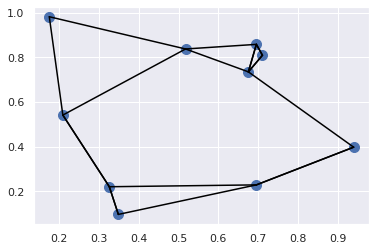

In [111]:
plt.scatter(X[:, 0], X[:, 1], s=100) # s=size

# draw lines from each point to its two nearest neighbors
K = 2

for i in range(X.shape[0]):
    for j in nearest_partition[i, :K+1]:
        # plot a line from X[i] to X[j]
        # use some zip magic to make it happen:
        plt.plot(*zip(X[j], X[i]), color='black')

Each point in the plot has lines drawn to its two nearest neighbors.
At first glance, it might seem strange that some of the points have more than two lines coming out of them: this is due to the fact that if point A is one of the two nearest neighbors of point B, this does not necessarily imply that point B is one of the two nearest neighbors of point A.

Although the broadcasting and row-wise sorting of this approach might seem less straightforward than writing a loop, it turns out to be a very efficient way of operating on this data in Python.
You might be tempted to do the same type of operation by manually looping through the data and sorting each set of neighbors individually, but this would almost certainly lead to a slower algorithm than the vectorized version we used. The beauty of this approach is that it's written in a way that's agnostic to the size of the input data: we could just as easily compute the neighbors among 100 or 1,000,000 points in any number of dimensions, and the code would look the same.

Finally, I'll note that when doing very large nearest neighbor searches, there are tree-based and/or approximate algorithms that can scale as $\mathcal{O}[N\log N]$ or better rather than the $\mathcal{O}[N^2]$ of the brute-force algorithm. One example of this is the KD-Tree, [implemented in Scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html).

## Aside: Big-O Notation

Big-O notation is a means of describing how the number of operations required for an algorithm scales as the input grows in size.
To use it correctly is to dive deeply into the realm of computer science theory, and to carefully distinguish it from the related small-o notation, big-$\theta$ notation, big-$\Omega$ notation, and probably many mutant hybrids thereof.
While these distinctions add precision to statements about algorithmic scaling, outside computer science theory exams and the remarks of pedantic blog commenters, you'll rarely see such distinctions made in practice.
Far more common in the data science world is a less rigid use of big-O notation: as a general (if imprecise) description of the scaling of an algorithm.
With apologies to theorists and pedants, this is the interpretation we'll use throughout this book.

Big-O notation, in this loose sense, tells you how much time your algorithm will take as you increase the amount of data.
If you have an $\mathcal{O}[N]$ (read "order $N$") algorithm that takes 1 second to operate on a list of length *N*=1,000, then you should expect it to take roughly 5 seconds for a list of length *N*=5,000.
If you have an $\mathcal{O}[N^2]$ (read "order *N* squared") algorithm that takes 1 second for *N*=1000, then you should expect it to take about 25 seconds for *N*=5000.

For our purposes, the *N* will usually indicate some aspect of the size of the dataset (the number of points, the number of dimensions, etc.). When trying to analyze billions or trillions of samples, the difference between $\mathcal{O}[N]$ and $\mathcal{O}[N^2]$ can be far from trivial!

Notice that the big-O notation by itself tells you nothing about the actual wall-clock time of a computation, but only about its scaling as you change *N*.
Generally, for example, an $\mathcal{O}[N]$ algorithm is considered to have better scaling than an $\mathcal{O}[N^2]$ algorithm, and for good reason. But for small datasets in particular, the algorithm with better scaling might not be faster.
For example, in a given problem an $\mathcal{O}[N^2]$ algorithm might take 0.01 seconds, while a "better" $\mathcal{O}[N]$ algorithm might take 1 second.
Scale up *N* by a factor of 1,000, though, and the $\mathcal{O}[N]$ algorithm will win out.

Even this loose version of Big-O notation can be very useful when comparing the performance of algorithms, and we'll use this notation throughout the book when talking about how algorithms scale.

<!--NAVIGATION-->
< [1.7 – Fancy_Indexing](L17_Fancy_Indexing.ipynb) | [Contents](../index.ipynb) | [1.9 – Structured Data NumPy](L19_Structured_Data_NumPy.ipynb) >

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; also available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*